<a href="https://colab.research.google.com/github/swisscheese38/tfcatflap/blob/main/tryoutmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try out the model
According to https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py
## Install dependencies

In [2]:
!pip install tflite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 4.6 MB/s 


## Download the model

In [35]:
!wget https://github.com/swisscheese38/tfcatflap/raw/main/model.tflite -O model.tflite

--2022-12-09 11:40:04--  https://github.com/swisscheese38/tfcatflap/raw/main/model.tflite
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/swisscheese38/tfcatflap/main/model.tflite [following]
--2022-12-09 11:40:04--  https://raw.githubusercontent.com/swisscheese38/tfcatflap/main/model.tflite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4444716 (4.2M) [application/octet-stream]
Saving to: ‘model.tflite’

model.tflite        100%[===================>]   4.24M  --.-KB/s    in 0.08s   

2022-12-09 11:40:05 (56.0 MB/s) - ‘model.tflite’ saved [4444716/4444716]



## Detect snouts
Place a random 'img.jpg' file in the Jupyter notebook's workspace

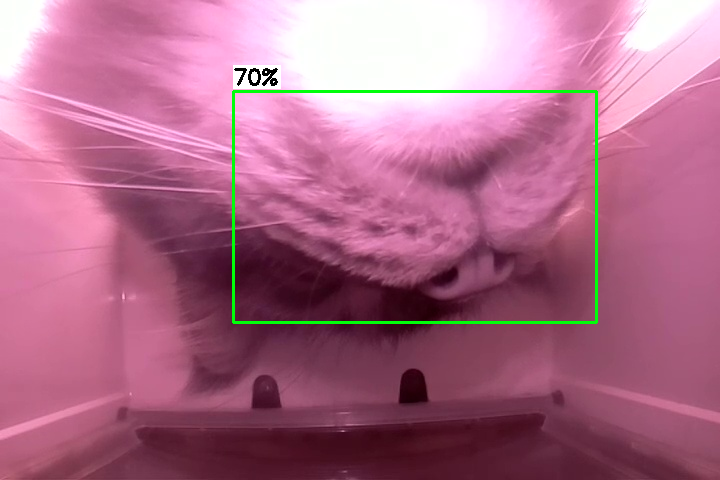

In [37]:
import cv2
import numpy as np
from tensorflow.lite.python.interpreter import Interpreter
from google.colab.patches import cv2_imshow

min_conf_threshold = 0.5
interpreter = Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

image = cv2.imread('img.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imH, imW, _ = image.shape 
image_resized = cv2.resize(image_rgb, (width, height))
input_data = np.expand_dims(image_resized, axis=0)

# Perform the actual detection by running the model with the image as input
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Retrieve detection results
boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):
          
            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

            # Draw label
            label = '%d%%' % (int(scores[i] * 100))
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            label_ymin = max(ymin, labelSize[1] + 10)
            cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text


cv2_imshow(image)